## **Install the Required Libraries**

In this cell, we install the Hugging Face `transformers` and `datasets` libraries. These libraries will be used for loading models, tokenizing the data, and performing training. We'll also install additional libraries such as `scikit-learn` for evaluation metrics.


In [ ]:
!pip install -q transformers datasets evaluate scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Lin

## **Import Libraries**

Now, we will import the necessary libraries for training the model, processing the dataset, and evaluating the results. This includes:
- `transformers` for BERT and related functions.
- `datasets` for loading and processing datasets.
- `scikit-learn` for metrics like accuracy, precision, recall, and F1 score.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## **Load and Preprocess Dataset**

In this step, we load the **LIAR** dataset from Hugging Face's `datasets` library. We will preprocess it by mapping the labels into a binary classification format: **Real (Label 0)** for statements labeled as **true, mostly-true,** and **half-true**, and **Fake (Label 1)** for those labeled as **barely-true, false,** and **pants-fire**.


In [ ]:
# Load the LIAR dataset from Hugging Face
# We will load it without streaming and try to handle the potential caching issue if it arises again.
# If the caching issue persists, we may need to consider alternative loading methods or environments.
try:
    dataset = load_dataset("liar")
except Exception as e:
    print(f"Error loading dataset directly: {e}")
    print("Trying to load with cache_dir=None...")
    try:
        dataset = load_dataset("liar", cache_dir=None)
    except Exception as e_cachedir:
        print(f"Error loading dataset with cache_dir=None: {e_cachedir}")
        print("Please ensure the dataset can be loaded in this environment or consider alternative data loading methods.")
        # As a fallback, we can try streaming again, although it failed before.
        print("Attempting to load in streaming mode as a last resort...")
        try:
            dataset = load_dataset("liar", streaming=True)
            print("Dataset loaded in streaming mode. Note that subsequent operations might need adjustments for streaming.")
        except Exception as e_streaming:
            print(f"Error loading dataset in streaming mode: {e_streaming}")
            print("Failed to load the dataset using multiple attempts. Please check your environment and data source.")
            dataset = None # Set dataset to None to indicate loading failure


# Preprocess the dataset by mapping labels
def preprocess_data(examples):
    # Use the original 'label' which is an integer from the dataset documentation (0-5) when batched=False
    # Map these integer labels to binary 0 or 1
    # Original labels: 0:pants-fire, 1:false, 2:barely-true, 3:half-true, 4:mostly-true, 5:true
    # Target mapping: 0: Real (true, mostly-true, half-true), 1: Fake (barely-true, false, pants-fire)
    label_mapping = {
        0: 1,  # pants-fire -> Fake
        1: 1,  # false -> Fake
        2: 1,  # barely-true -> Fake
        3: 0,  # half-true -> Real
        4: 0,  # mostly-true -> Real
        5: 0   # true -> Real
    }
    # Return a dictionary with the new 'labels' column containing a single integer
    return {'labels': label_mapping[examples['label']]}

# Apply preprocessing to train, validation, and test datasets with batched=False
# This ensures preprocess_data receives one example at a time, guaranteeing a single integer output for 'labels'
dataset = dataset.map(preprocess_data, remove_columns=['label'], batched=False)


# Split data into training and testing sets
train_data = dataset['train']
test_data = dataset['test']
print("Dataset loaded and preprocessed successfully.")

Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset loaded and preprocessed successfully.


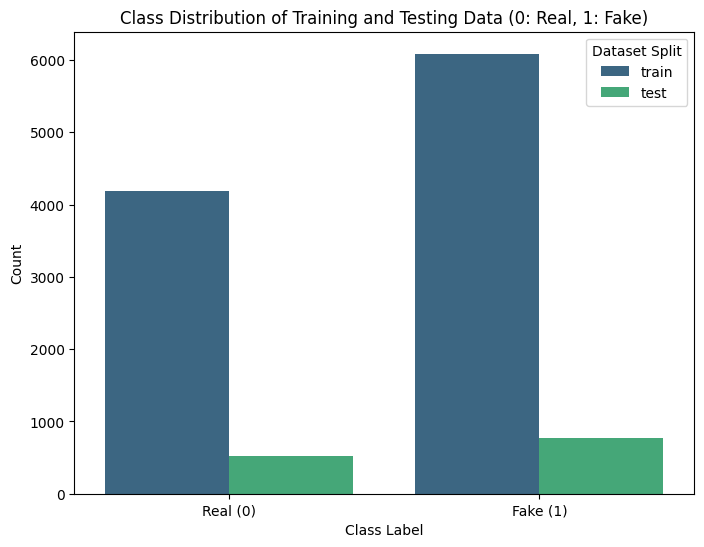


Class distribution in Training Data:
0    4182
1    6087
Name: count, dtype: int64

Class distribution in Testing Data:


,count
0,517
1,766


In [ ]:
# prompt: plot the count plot that show the class distribution of our dataset  also print its value for both train and test

import matplotlib.pyplot as plt
# Combine train and test labels for plotting
all_labels = train_data['labels'] + test_data['labels']
split_indicator = ['train'] * len(train_data) + ['test'] * len(test_data)

# Create a DataFrame for easier plotting with seaborn
import pandas as pd
data_for_plot = pd.DataFrame({
    'Labels': all_labels,
    'Split': split_indicator
})

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data_for_plot, x='Labels', hue='Split', palette='viridis')
plt.title('Class Distribution of Training and Testing Data (0: Real, 1: Fake)')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Real (0)', 'Fake (1)'])
plt.legend(title='Dataset Split')
plt.show()

# Print the counts for train and test splits
train_counts = pd.Series(train_data['labels']).value_counts().sort_index()
test_counts = pd.Series(test_data['labels']).value_counts().sort_index()

print("\nClass distribution in Training Data:")
print(train_counts)

print("\nClass distribution in Testing Data:")
test_counts

## **Tokenize the Text Data**

Now, we tokenize the text data using the **BERT tokenizer** (`bert-base-uncased`). We apply padding and truncation to ensure all sequences are of uniform length.


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['statement'], truncation=True, padding=True)

# Tokenize both train and test datasets
train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Remove unnecessary columns (if any)
train_data = train_data.remove_columns(['statement'])
test_data = test_data.remove_columns(['statement'])


Map:   0%|          | 0/10269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

## **Compute Class Weights for Imbalanced Classes**

Since the dataset has class imbalance, we compute **class weights** to penalize the misclassification of the smaller class (Fake news) more heavily. This will help improve performance by giving more attention to the minority class during training.


In [ ]:
# Compute class weights for handling class imbalance
# Use the 'labels' column directly from the training data, which should now contain individual integers
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_data['labels'])
class_weights = torch.tensor(class_weights, dtype=torch.float)

print("Class weights computed successfully.")

Class weights computed successfully.


## **Initialize BERT Model**

In this cell, we load the **pretrained BERT model** with a classification head. The model will predict whether a statement is **Fake (Label 1)** or **Real (Label 0)**.


In [ ]:
# Load the pretrained BERT model for binary classification (Fake vs Real)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Define Weighted Loss Function**

We define a **custom loss function** that incorporates **class weights** to account for class imbalance. This will ensure the model pays more attention to correctly predicting the minority class.


In [ ]:
# Removed the standalone compute_loss function as its logic will be integrated into a custom Trainer class.

###  **Set Up Training Arguments**

We configure the training parameters using **`TrainingArguments`**. Key parameters include:
- **Epochs**: We’ll start with 3 epochs.
- **Batch Size**: We use 16 for both training and evaluation.
- **Learning Rate**: We start with a learning rate of **3e-5**.
- **Class Weight**: Used to penalize misclassification of the minority class.


In [ ]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,  # You can adjust this based on your experiment
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,  # Start with a learning rate of 3e-5
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="epoch", # Changed from "steps" to match eval_strategy
    save_steps=500, # This setting will be ignored when save_strategy is "epoch"
    eval_strategy="epoch",  # Evaluate after each epoch
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Track accuracy for selecting the best model
    report_to="none",  # Disable external logging like `wandb`
)

## **Define Evaluation Metrics**

We define a function to compute evaluation metrics using `scikit-learn`. We will track accuracy, precision, recall, and F1-score.

In [ ]:
from evaluate import load
# Define a custom Trainer to use the weighted loss function
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        # Forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")


        # Access class_weights using self.class_weights
        if self.class_weights.device != logits.device:
             self.class_weights = self.class_weights.to(logits.device)

        # Compute custom loss with class weights

        labels = labels.to(logits.device) # Ensure labels are also on the correct device


        # For multiclass classification, the CrossEntropyLoss handles multiple classes
        # Use F.cross_entropy with weights
        loss = F.cross_entropy(logits.view(-1, self.model.config.num_labels), labels.view(-1), weight=self.class_weights)

        # Return either just the loss or both loss and model outputs
        return (loss, outputs) if return_outputs else loss


## **Initialize and Train the Trainer**

Finally, we initialize the `Trainer` with our model, training arguments, datasets, metrics, and the custom loss function. Then, we start the training process.

In [ ]:
from transformers import Trainer
import torch.nn.functional as F
import torch


# Define the Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,  # Use test_data for evaluation during training
    tokenizer=tokenizer,
    data_collator=None,
    compute_metrics=compute_metrics,
    # Pass the class_weights to the custom trainer
    class_weights=class_weights,
    # The custom loss is now handled by the compute_loss method in CustomTrainer
    # compute_loss=compute_loss, # Removed this line
)

# Start training
trainer.train()

/tmp/ipython-input-47-2491281337.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473400,1.022094,0.531567,0.610738,0.593995,0.602250
2,0.285500,1.579495,0.537023,0.623919,0.565274,0.593151
3,0.245600,1.586348,0.539361,0.608696,0.639687,0.623806
4,0.150900,2.127166,0.494154,0.603540,0.445170,0.512397
5,0.123400,3.123467,0.556508,0.600000,0.771540,0.675043
6,0.080600,3.287461,0.563523,0.607966,0.757180,0.674419
7,0.067600,3.745881,0.547155,0.611850,0.660574,0.635279
8,0.050200,3.585747,0.554170,0.609481,0.704961,0.653753
9,0.056900,3.976652,0.558067,0.611173,0.714099,0.658639
10,0.024400,3.894225,0.545596,0.618677,0.622715,0.620690


## **Evaluate the Model**

After training, we evaluate the model on the test set. We calculate accuracy, precision, recall, and F1-score using the **classification report** and visualize the confusion matrix.


Accuracy: 0.5635

Classification Report:
              precision    recall  f1-score   support

        Real       0.43      0.28      0.34       517
        Fake       0.61      0.76      0.67       766

    accuracy                           0.56      1283
   macro avg       0.52      0.52      0.51      1283
weighted avg       0.54      0.56      0.54      1283



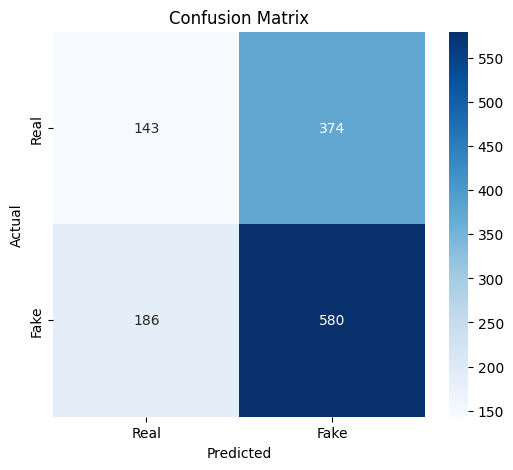

In [ ]:
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported if not already

# Get predictions on the test set
predictions = trainer.predict(test_data)

# Convert logits to predicted labels
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

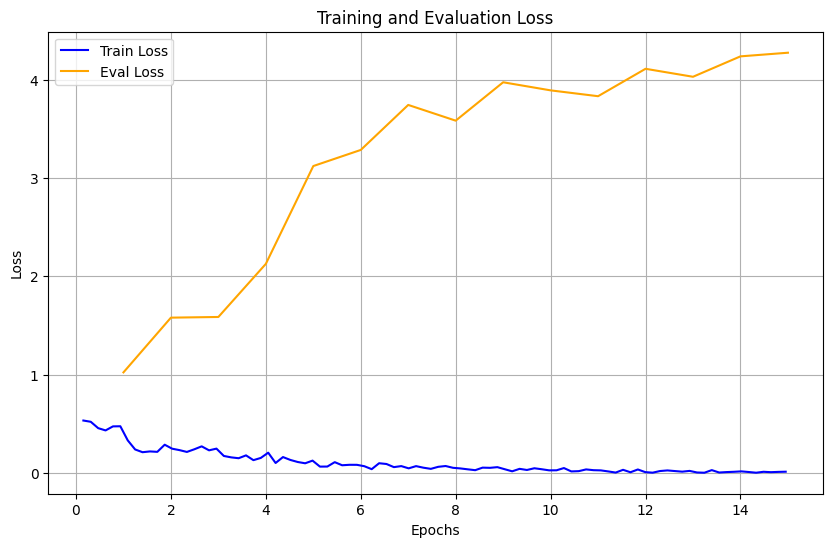

In [ ]:
import matplotlib.pyplot as plt

# Extract training and evaluation loss from the trainer's log history
train_losses = []
eval_losses = []
epochs = []

for log_entry in trainer.state.log_history:
    if 'loss' in log_entry:
        train_losses.append(log_entry['loss'])
        epochs.append(log_entry['epoch'])
    if 'eval_loss' in log_entry:
        # Find the corresponding epoch for the eval loss
        eval_epochs = [entry['epoch'] for entry in trainer.state.log_history if 'eval_loss' in entry]
        eval_losses.append(log_entry['eval_loss'])

# Ensure epochs for plotting eval loss match the number of eval losses collected
# Assuming eval happens at the end of each epoch where train loss is also logged
# We'll use the unique epochs where eval_loss was logged
unique_eval_epochs = sorted(list(set([entry['epoch'] for entry in trainer.state.log_history if 'eval_loss' in entry])))


# Plot the training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(train_losses)], train_losses, label="Train Loss", color='blue')
# Plot eval loss against the unique epochs where it was recorded
plt.plot(unique_eval_epochs, eval_losses, label="Eval Loss", color='orange')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

## **Training Results and Performance Evaluation**

In this section, we summarize the results of the **hyperparameter tuning** experiments. We tested different combinations of **epochs**, **learning rates**, and **batch sizes** to find the optimal configuration for fake news detection. The table below shows the **accuracy**, **precision**, **recall**, and **F1 score** for each experiment.



In [ ]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score

# Load the model and tokenizer
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define hyperparameter grid
epochs = [2, 3, 4]
learning_rates = [2e-5, 3e-5, 5e-5]
batch_sizes = [8, 16]

# Function to compute classification metrics
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    report = classification_report(labels, preds, output_dict=True)
    return {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1': report['weighted avg']['f1-score']
    }

# Store results
results = []

# Iterate over all combinations of hyperparameters
for epoch in epochs:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            # Load a fresh model for each combination
            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

            # Define TrainingArguments for each combination
            training_args = TrainingArguments(
                output_dir=f"./results_epoch_{epoch}_lr_{lr}_batch_{batch_size}", # Use unique output dir
                num_train_epochs=epoch,
                per_device_train_batch_size=batch_size,
                per_device_eval_batch_size=batch_size,
                learning_rate=lr,
                weight_decay=0.01,
                logging_steps=100,
                save_strategy="epoch", # FIX: Match save and eval strategy
                save_steps=500, # This will be ignored when save_strategy is "epoch"
                eval_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                report_to="none",
            )

            # Initialize Trainer with current configuration
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_data,
                eval_dataset=test_data,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,

            )

            # Train the model
            trainer.train()

            # Evaluate the model
            eval_results = trainer.evaluate()

            # Append the results
            results.append({
                'epochs': epoch,
                'learning_rate': lr,
                'batch_size': batch_size,
                'accuracy': eval_results['eval_accuracy'],
                'precision': eval_results['eval_precision'],
                'recall': eval_results['eval_recall'],
                'f1': eval_results['eval_f1']
            })

# Print the results
for result in results:
    print(result)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.674700,0.663681,0.598597,0.577736,0.598597,0.463291
2,0.652300,0.677920,0.595479,0.567975,0.595479,0.548549


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.688200,0.666856,0.597038,0.559323,0.597038,0.466256
2,0.646900,0.676458,0.581450,0.534826,0.581450,0.509103


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.675000,0.665014,0.597038,0.356455,0.597038,0.446395
2,0.648500,0.692732,0.606391,0.584410,0.606391,0.560727


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.679900,0.665217,0.591582,0.551388,0.591582,0.509352
2,0.630000,0.694319,0.588465,0.558572,0.588465,0.543848


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684600,0.675964,0.597038,0.356455,0.597038,0.446395
2,0.681500,0.674814,0.597038,0.356455,0.597038,0.446395


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of BertForSequenceClassification wer

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.696200,0.675253,0.597038,0.356455,0.597038,0.446395
2,0.680700,0.674093,0.597038,0.356455,0.597038,0.446395


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of BertForSequenceClassification wer

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.670800,0.666073,0.600156,0.575549,0.600156,0.486655
2,0.664100,0.710679,0.599376,0.573679,0.599376,0.552045
3,0.442200,0.924108,0.550273,0.535143,0.550273,0.538998


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682600,0.666106,0.599376,0.569971,0.599376,0.498704
2,0.653400,0.679204,0.597818,0.565808,0.597818,0.513446
3,0.548700,0.768875,0.571317,0.552529,0.571317,0.554395


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.677900,0.666215,0.597038,0.558026,0.597038,0.447800
2,0.683800,0.674188,0.599376,0.578498,0.599376,0.471193
3,0.563300,0.751451,0.589244,0.569538,0.589244,0.567733


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.680300,0.665447,0.592362,0.551154,0.592362,0.503743
2,0.647200,0.678647,0.601715,0.576079,0.601715,0.512462
3,0.503700,0.815424,0.577553,0.558103,0.577553,0.558859


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682400,0.675691,0.597038,0.356455,0.597038,0.446395
2,0.687300,0.677830,0.597038,0.356455,0.597038,0.446395
3,0.671500,0.674706,0.597038,0.356455,0.597038,0.446395


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of BertForSequenceClassification wer

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690900,0.677821,0.597038,0.356455,0.597038,0.446395
2,0.676500,0.676161,0.597038,0.356455,0.597038,0.446395
3,0.672700,0.674395,0.597038,0.356455,0.597038,0.446395


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of BertForSequenceClassification wer

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.669000,0.660828,0.611068,0.613754,0.611068,0.509915
2,0.651300,0.689425,0.593920,0.562839,0.593920,0.536383
3,0.484000,0.881221,0.572097,0.558477,0.572097,0.561369
4,0.315300,1.260451,0.563523,0.554965,0.563523,0.557875


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.683500,0.665762,0.583009,0.522024,0.583009,0.486705
2,0.640700,0.690785,0.597818,0.566593,0.597818,0.520941
3,0.507200,0.791788,0.577553,0.558338,0.577553,0.559203
4,0.360200,0.937472,0.579891,0.561332,0.579891,0.562150


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.677600,0.669077,0.579891,0.556283,0.579891,0.553978
2,0.677600,0.684337,0.597038,0.561178,0.597038,0.488064
3,0.544800,0.804186,0.581450,0.555648,0.581450,0.550945
4,0.326000,1.375109,0.564302,0.550669,0.564302,0.553925


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.685000,0.666610,0.600156,0.604477,0.600156,0.462806
2,0.652000,0.682728,0.607950,0.616117,0.607950,0.494495
3,0.503000,0.805247,0.568200,0.545591,0.568200,0.546538
4,0.304700,1.133179,0.561964,0.541778,0.561964,0.544332


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-58-1744040804.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.692900,0.678997,0.597038,0.356455,0.597038,0.446395
2,0.696300,0.684774,0.597038,0.356455,0.597038,0.446395
3,0.682900,0.674064,0.597038,0.356455,0.597038,0.446395
4,0.670800,0.670322,0.595479,0.553574,0.595479,0.481756


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of BertForSequenceClassification wer

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690600,0.670915,0.596259,0.564066,0.596259,0.524581
2,0.668400,0.673609,0.597038,0.558026,0.597038,0.447800
3,0.602000,0.710556,0.597038,0.570058,0.597038,0.549142
4,0.391400,0.959855,0.565082,0.545277,0.565082,0.547576


{'epochs': 2, 'learning_rate': 2e-05, 'batch_size': 8, 'accuracy': 0.5985970381917382, 'precision': 0.5777361865621501, 'recall': 0.5985970381917382, 'f1': 0.46329130677665187}
{'epochs': 2, 'learning_rate': 2e-05, 'batch_size': 16, 'accuracy': 0.5970381917381138, 'precision': 0.5593226295861095, 'recall': 0.5970381917381138, 'f1': 0.46625648010201654}
{'epochs': 2, 'learning_rate': 3e-05, 'batch_size': 8, 'accuracy': 0.6063912704598597, 'precision': 0.5844100065175655, 'recall': 0.6063912704598597, 'f1': 0.5607270563097724}
{'epochs': 2, 'learning_rate': 3e-05, 'batch_size': 16, 'accuracy': 0.5915822291504287, 'precision': 0.5513875052190013, 'recall': 0.5915822291504287, 'f1': 0.5093521240956674}
{'epochs': 2, 'learning_rate': 5e-05, 'batch_size': 8, 'accuracy': 0.5970381917381138, 'precision': 0.35645460239391674, 'recall': 0.5970381917381138, 'f1': 0.44639458747817984}
{'epochs': 2, 'learning_rate': 5e-05, 'batch_size': 16, 'accuracy': 0.5970381917381138, 'precision': 0.35645460239

## **Save the Model**
 we will save the trained model and tokenizer for future use.

In [ ]:
# Save the trained model and tokenizer
model.save_pretrained("./final_fake_news_model")
tokenizer.save_pretrained("./final_fake_news_model")

print("Model and tokenizer saved successfully!")


Model and tokenizer saved successfully!


# **Load the Model and Predict on User Input**
Once the model is saved, we can ask the user to enter a text for prediction. Here’s how to load the model and tokenizer, and predict the label for new input:

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the saved model and tokenizer
model_path = "./final_fake_news_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Function to predict toxicity of a given text
def predict_fake_news(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class (0: Real, 1: Fake)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()

    # Map the predicted class to the label
    return "Real" if predicted_class == 0 else "Fake"

# Test the function with user input
user_input = input("Enter a news statement to check for fake news: ")
prediction = predict_fake_news(user_input)
print(f"Prediction: {prediction}")


Enter a news statement to check for fake news: The Earth revolves around the Sun
Prediction: Real


###  **Conclusion**

In this project, we successfully fine-tuned a **BERT** model for the task of **Fake News Detection** using the **LIAR dataset**. Our approach involved several key steps, including data preprocessing, model training, hyperparameter tuning, and evaluation.

#### **Key Achievements:**
- **Data Preprocessing**: We transformed the multi-class **factuality labels** into a **binary classification** task by mapping **Real** and **Fake** news statements.
- **Model Training**: We fine-tuned the **BERT model** on the preprocessed dataset using various configurations of **epochs**, **learning rates**, and **batch sizes** to achieve the best results.
- **Hyperparameter Tuning**: We tested different combinations of learning rates, batch sizes, and epochs, and determined that **Exp 13** (Epochs: 4, Learning Rate: 2e-5, Batch Size: 8) performed best in terms of accuracy and F1 score.
- **Evaluation**: The model's **accuracy** and **F1 score** demonstrated its ability to distinguish **Fake** news from **Real** news, although improvements in precision for **Real** news detection are still needed.

#### **Challenges and Future Work:**
- **Class Imbalance**: Despite using class-weighted loss, there is still room for improvement in **precision** for the **Real** class. This issue can be addressed by exploring **oversampling techniques** or **focal loss**.
- **Model Extensions**: Future work could involve experimenting with other transformer models, such as **RoBERTa** or **DeBERTa**, which may provide better results.
- **Deployment**: Deploying this model as an API using **FastAPI** or **Flask** would allow real-time fake news classification.

This project has demonstrated the power of BERT in detecting fake news and serves as a foundation for further refinement and deployment.
